# Bagging and Random Forests
### Jack Bennetto
### July 10, 2017

In [140]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.special import comb

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import log_loss, make_scorer
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.datasets import load_breast_cancer, load_iris

## Objectives


 * Explain the relationship and difference between bagging and a random forest.
 * Explain why bagging/random forests are more accurate than a single decision tree.
 * Explain & construct a random forest (classification or regression).
 * Get feature importances from a random forest.
 * Explain how OOB error is calculated and what it estimates.

## Agenda

 * Discuss ensemble methods
 * Review bias/variance tradeoff
 * Review decision trees
 * Discuss bagging (bootstrap aggregation)
 * Discuss random forests
 * Discuss out-of-bag error
 * Discuss feature importance

## What is an Ensemble Method?

In general, an **ensemble** method combines many weak models to form a strong model. We train multiple models on the data, such that each is different. They could be trained on different subsets of the data, or trained in different ways, or even be completely different types of models.

Once we've done that, we need to combine the models to form a single model.

Class discussion: how would get a single prediction from an ensemble of **regression** models?

Class discussion: how would get a single prediction from an ensemble of **classification** models?



## Ensembles: Intuition

Suppose we have 5 *independent* hard binary classifers (they only give 0 or 1 probability). If they are each  70% accurate, what's the accuracy of an ensemble of them?

Question: what does independent mean?

In [2]:
def find_ensemble_accuracy(n, p):
    '''Given a n independent classifiers each of p accuracy,
    return the emsumble accuracy'''
    ensemble_accuracy = 0
    for k in range((n + 1) // 2, n+1):
        ensemble_accuracy += comb(n, k) * p**k * (1-p)**(n-k)
    return ensemble_accuracy

In [3]:
find_ensemble_accuracy(5, 0.7)

0.83691999999999989

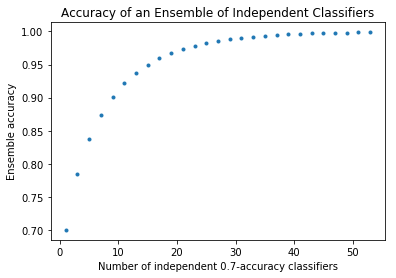

In [4]:
ns = np.arange(1, 55, 2)
vfea = np.vectorize(find_ensemble_accuracy, excluded=['p'])
ensemble_accuracies = vfea(ns, p=0.7)

fig, ax = plt.subplots()
ax.plot(ns, ensemble_accuracies, '.')
ax.set_ylabel("Ensemble accuracy")
ax.set_xlabel("Number of independent 0.7-accuracy classifiers")
ax.set_title("Accuracy of an Ensemble of Independent Classifiers")

$$ \binom{5}{5} 0.7^5 + \binom{5}{4} 0.7^4 0.3 + \binom{5}{3} 0.7^3 0.3^2 \approx 0.83 $$

With 55 such classifiers we can achieve 99.9% accuracy.


Question: what's the limitation?

## How to Make Them Independent?

If the learners are all the same, ensembles don't help.

Train each learner on different subset of data.

Question: Why is this better than a single good model?

## Bias and Variance

Question: what is bias?

Question: what is variance?

Question: what is the bias of an unpruned decision tree?

## Review: Classification Trees

A **classification tree** is a decision tree to predicts whether a data point is in one class or another. Each branch node is a decision, choosing left or right based on the value of a certain feature. Each leaf node gives the probability that a data point is in one class or another.

Let's look at the tennis dataset from the other day.

In [5]:
# Read in our data
tennis_df = pd.read_table('data/tennis.txt', delim_whitespace=True)
tennis_df.rename(columns={'playtennis': 'played'}, inplace=True)
#tennis_df['played'] = tennis_df['played'].apply(lambda x: 1 if x == 'yes' else 0)
tennis_df

,outlook,temperature,humidity,wind,played
0,sunny,hot,high,False,no
1,sunny,hot,high,True,no
2,overcast,hot,high,False,yes
3,rainy,mild,high,False,yes
4,rainy,cool,normal,False,yes
5,rainy,cool,normal,True,no
6,overcast,cool,normal,True,yes
7,sunny,mild,high,False,no
8,sunny,cool,normal,False,yes
9,rainy,mild,normal,False,yes


You probably need to do `pip install graphviz` to generate this.

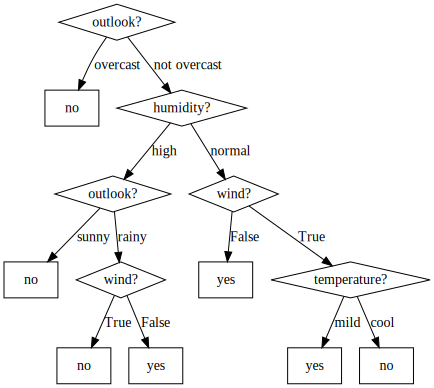

In [6]:
from graphviz import Digraph
dot = Digraph(comment='A simple classification tree')

dot.node('O', 'outlook?', shape='diamond')
dot.node('1', "no", shape='rectangle')
dot.node('H', 'humidity?', shape='diamond')
dot.node('O2', 'outlook?', shape='diamond')
dot.node('W', 'wind?', shape='diamond')
dot.node('3', 'yes', shape='rectangle')
dot.node('T', 'temperature?', shape='diamond')
dot.node('4', 'yes', shape='rectangle')
dot.node('5', "no", shape='rectangle')
dot.node('2', "no", shape='rectangle')
dot.node('W2', 'wind?', shape='diamond')
dot.node('6', "no", shape='rectangle')
dot.node('7', 'yes', shape='rectangle')

dot.edge('O', '1', 'overcast')
dot.edge('O', 'H', 'not overcast')
dot.edge('H', 'O2', 'high')
dot.edge('H', 'W', 'normal')
dot.edge('W', '3', 'False')
dot.edge('W', 'T', 'True')
dot.edge('T', '4', 'mild')
dot.edge('T', '5', 'cool')
dot.edge('O2', '2', 'sunny')
dot.edge('O2', 'W2', 'rainy')
dot.edge('W2', '7', 'False')
dot.edge('W2', '6', 'True')
dot

A classification tree is built by

* Iteratively divide the nodes such that (entropy/gini impurity) is minimized
* Various stopping conditions like a depth limit
* Prune trees by merging nodes

## Review: Regression Trees

A **regression tree** predicting a number rather than the probability that something is in one class or another. Prediction works the same as with classification trees, but the leaf nodes give a number rather than probabilities of a class.

To train a regression tree, we

* Iteratively divide the nodes such that *total squared error* is minimized,

$$\sum_{i \in L} (y_i - m_L)^2 + \sum_{i\in R} (y_i - m_R)^2$$

* Use various stopping conditions like a depth limit, minimum leaf size, and
* Prune trees by merging nodes

## Regression Trees: Example

 $x_1$ |   $x_2$ |  $y$
-------|---------|--------
 1     |    1    |   1
 0     |    0    |   2
 1     |    0    |   3
 0     |    1    |   4

 Prior to the split we guess the mean, 2.5, for everything, giving total squared error:
 
 $$ E = (1-2.5)^2 + (2-2.5)^2 + (3-2.5)^2 + (4-2.5)^2  = 5$$
 After we split on $x_1$ we guess 2 for rows 1 & 3 and 3 for rows 2 & 4:
 
 $$ E = (1-2)^2 + (3-2)^2 + (2-3)^2 + (4-3)^2 = 4 $$

## Decision Tree Summary

What are the pros and cons?

Pros
 * No feature scaling needed
 * Model nonlinear relationships
 * Can do both classification and regression
 * Robust
 * Highly interpretable

Cons
 * Can be expensive to train
 * Often poor predictors because of high variance


## Review: Bootstrapping

What is a bootstrap sample?

What have we learned that bootstrap samples are good for so far?

Let's get the median of some data.

In [7]:
data = stats.uniform(0,10).rvs(100)
np.median(data)

5.4256679529796576

What's the confidence interval of this estimate?

In [8]:
def bootstrap_confidence_interval(data, function, alpha=0.05, n_bootstraps=1000):
    '''return a the confidence interval for a function of data using bootstrapping'''
    medians = []
    for _ in range(n_bootstraps):
        bootstrap_sample = np.random.choice(data, len(data))
        medians.append(function(bootstrap_sample))
    return (np.percentile(medians, 100*(alpha/2.)),
            np.percentile(medians, 100*(1-alpha/2.)))

In [9]:
alpha = .05
ci = bootstrap_confidence_interval(data, np.median, alpha)

print("The {}% confidence interval is from {} to {}".format(1-alpha, *ci))

The 0.95% confidence interval is from 3.917204814623134 to 6.056261208689428


Our procedure was
  * Take 1000 bootstrap samples.
  * Take the median of each sample.
  * The 95% confidence inverval for the median is between the 25th and 975th largest samples.
  
To confirm this worked, let's do it a bunch of times.

In [10]:
hits = []
for _ in range(100):
    data = stats.uniform(0,10).rvs(100)
    ci = bootstrap_confidence_interval(data, np.median)
    hits.append(ci[0] < 5.0 and ci[1] > 5.0)
print(np.mean(hits))

0.9


Maybe that didn't work, but it would have if we'd done it a lot longer.

## Bootstrapped aggregation

 * We are thinking about the population of all possible decision tree models on our data.
 * If I take $n$ samples *iid* from this distribution and average them the variance goes down by $\sqrt n$
 * There is some correlation between models because they are all trained on bootstrap samples from the same draw.

## An Experiment

You're each going to be a decision tree on some data based on a bootstrap sample, and then we'll all ensemble the results.

In [31]:
data = load_iris()

# Split into test/train, using the same random state for everyone
X_train, X_test, y_train, y_test = train_test_split(data.data,
                                                    data.target,
                                                    random_state=462)

In [66]:
clf = DecisionTreeClassifier()
# each of you has a different bootstrap sample
bootstrap_sample = np.random.choice(range(len(X_train)),
                                    len(X_train),
                                    replace=True)
clf.fit(X_train[bootstrap_sample], y_train[bootstrap_sample])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [67]:
print("Accuracy = {:.3f}".format(np.mean(clf.predict(X_test) == y_test)))

Accuracy = 0.895


In [68]:
print("My prediction: {}".format(clf.predict(X_test)[0:20]))
print("Actual result: {}".format(y_test[0:20]))

My prediction: [0 2 0 2 2 1 2 2 0 2 2 0 2 2 2 2 1 2 1 0]
Actual result: [0 2 0 1 2 1 2 2 0 2 2 0 1 2 2 2 1 2 1 0]


What is your prediction?

This concept, creating each model from a bootstrap sample and aggregating the results, is called **bagging**. It could really be used with any sort of model, but is generally done with decision trees.

Question: why?

### Bootstraping on Regression Trees

Let's do another example. Consider some points.

In [88]:
n_data = 5000
x = stats.uniform(0, 10).rvs(n_data)
y = np.cos(x) + stats.norm(0, 0.5).rvs(n_data)

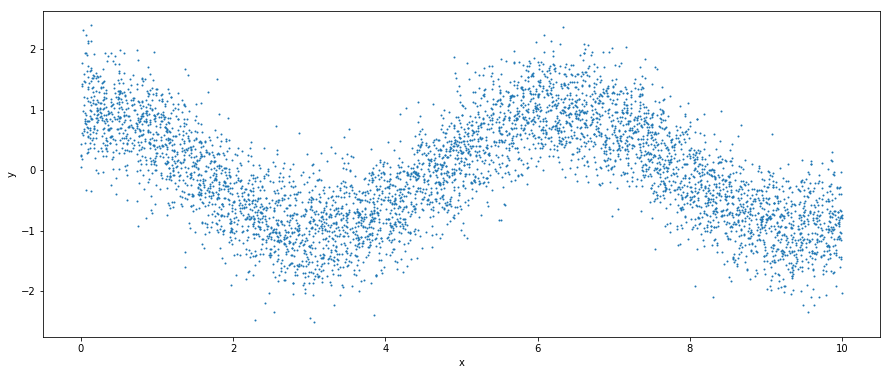

In [111]:
fig, ax = plt.subplots(figsize=(15,6))
ax.plot(x, y, '.', ms=2)
ax.set_xlabel('x')
ax.set_ylabel('y')

We'll create a decision tree to predict the points. We won't make it that deep because we want to visualize the prediction.

In [112]:
max_depth = 9
model = DecisionTreeRegressor(max_depth=max_depth)
model.fit(x.reshape(-1, 1), y)

DecisionTreeRegressor(criterion='mse', max_depth=9, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

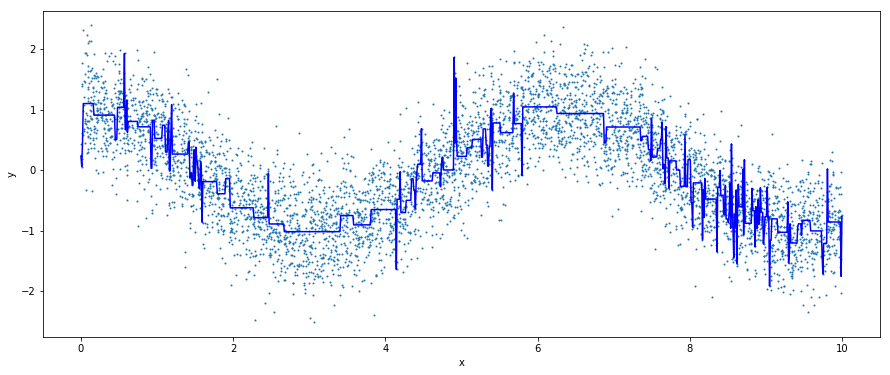

In [113]:
n_pts = 1000
xpts = np.linspace(0, 10, n_pts)
p1 = ax.plot(xpts, model.predict(xpts.reshape(-1, 1)), 'b')
fig

That's what one decision tree looks like; each discontinuity is a node split. What if we create a bunch of bootstrap samples and build an ensemble of trees from them?

In [114]:
n_bootstraps = 5000
yptses = np.zeros((n_bootstraps, n_pts))
for i in range(n_bootstraps):
    bootstrap = np.random.choice(np.arange(n_data), n_data, True)
    model = DecisionTreeRegressor(max_depth=max_depth)
    model.fit(x[bootstrap].reshape(-1, 1), y[bootstrap])
    yptses[i] = model.predict(xpts.reshape(-1, 1))


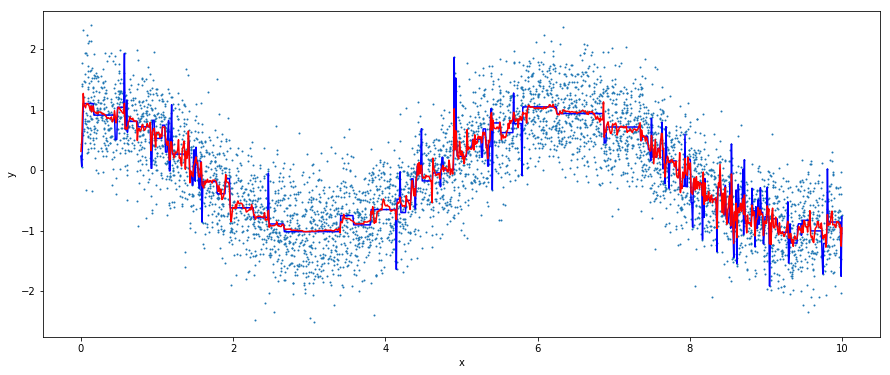

In [115]:
ax.plot(xpts, yptses.mean(axis=0), 'r')
fig

## Random Forests

Bagging decision trees are pretty cool, but the trees still tend to look pretty similar. We want a way to make the trees more different (decorrelate them) without substantially increasing the bias of each tree.

Random forests do this with **subspace sampling**. When we are building a tree and considering the feature to use at each split, we only consider a few of them, randomly choosen. The number of features $m$ to consider at each split is a hyperparameter; typically $m = \sqrt k$ is used.

Again, the features to consider are chosen **at each split**, not each tree. **Everyone gets this wrong.**

For example, suppose we're building a model with nine features. One of them is really predictive, another is pretty good, and the others are just ok.

If we build an ensemble of bagged trees, probably each will use the good feature as the first split, and probably each will use the pretty-good feature at the next split. For the other splits the trees might differ, particularly father down when only a few points are being considered, but the first branches will be pretty much the same.

If we build a trees in a random forest, we'll only consider three (random) features for that first split. Only a fraction of the trees (around 30%) will consider the good feature on the first split, so they will use that. Some of the others will consider the pretty-good feature, so they will start there. The others will start at some other feature. Those trees will still consider the good and pretty-good features at some of the lower nodes, and will get to take advantage of them, but the overall structure of those trees will be completely different.

## Random Forest Parameters

Random Forest Parameters

 * Total number of trees
 * Number of features to use at each split
 * Individual decision tree Parameters
    - e.g., tree depth, pruning, split criterion

In general, RF are fairly robust to the choice of parameters and overfitting.

## Pros and Cons of Random Forest

Pros

 * Often give near state-of-the-art performance
 * Good out-of-the-box performance
 * No feature scaling needed
 * Model nonlinear relationships

Cons

 * Can be expensive to train (though can be done in parallel)
 * Not interpretable

## Comparison to Decision Trees

Let's investigate the accuracy of a random forests compared with a single decision tree using the boston dataset. 

In [120]:
# Load Boston data
data = load_breast_cancer()
#data = pd.drop(data, )
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target)

X = X.drop(['worst concave points', 'mean concave points', 'worst perimeter', 'worst radius', 'worst area', 'mean concavity'], axis=1)
# Split into test/train
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=.33,
                                                    random_state=0)


In [121]:
X_train.columns

Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean symmetry',
       'mean fractal dimension', 'radius error', 'texture error',
       'perimeter error', 'area error', 'smoothness error',
       'compactness error', 'concavity error', 'concave points error',
       'symmetry error', 'fractal dimension error', 'worst texture',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst symmetry', 'worst fractal dimension'],
      dtype='object')

First, consider a decision tree, doing a grid search over hyperparameters.

In [138]:
clf.score?

In [151]:
# Parameter Search                                     
model = DecisionTreeClassifier()

depth_parm = np.arange(1, 12, 1)
num_samples_parm = np.arange(5,95,10)
parameters = {'max_depth' : depth_parm,
             'min_samples_leaf' : num_samples_parm}

scorer = make_scorer(log_loss,
                     greater_is_better=False,
                     needs_proba=True)
clf = GridSearchCV(model,
                   parameters,
                   cv=10,
                   scoring=scorer)
clf.fit(X_train,y_train)
print(f"log loss = {-clf.score(X_test, y_test)}")
print(f"accuracy = {(clf.predict(X_test) == y_test).mean()}")

log loss = 0.37657660776965657
accuracy = 0.898936170212766
log loss = 0.37658086094747667


In [24]:
clf.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [146]:
clf.best_params_

{'max_depth': 4, 'min_samples_leaf': 65}

Now random forests.

In [152]:

# Train and fit model                                                   
rf = RandomForestClassifier(n_estimators=1000,
                           max_features='auto',
                           random_state=0)
rf.fit(X_train, y_train)
                                     
# Test Prediction
pred = rf.predict(X_test)
print(f"log loss = {log_loss(y_test, rf.predict_proba(X_test)[:, 1])}")
print(f"accuracy = {rf.score(X_test, y_test)}")

log loss = 0.13903524850999485
accuracy = 0.9521276595744681


So that's better.

# Afternoon Lecture

## Interpreting Random Forests

## Objectives

Morning Objectives

 * Explain & construct a random forest (classification or regression).
 * Explain the relationship and difference between random forest and bagging.
 * Explain why random forests are more accurate than a single decision tree.

Afternoon Objectives

 * Get feature importances from a random forest.
 * Explain how OOB error is calculated and what is it an estimate of.

## Agenda

Morning Agenda

 * Discuss ensemble methods
 * Review bias/variance tradeoff
 * Review decision trees
 * Discuss bagging (bootstrap aggregation)
 * Discuss random forests

Afternoon Agenda

 * Discuss out-of-bag error
 * Discuss feature importance

## Review: Bagging and Random Forests

What is bagging?

Can bagging be used with other models?

What's the difference between bagging and random forests?

## Out-Of-Bag Error

The out-of-bag error is a way to measure the error of a bagged model (including random forests).

Since the decision trees are constructed from a bootstrap sample, each tree will (probably) not see all of the data, so each datum will (probably) not be see my many of the trees.

Let's imagine a data set with 10 points, and that we're making a random forest with 20 trees. We'll need 20 and construct 20 bootstrap samples.

In [153]:
n_data = 10
n_trees = 100000

np.random.seed(42)
bootstrap_samples = np.random.choice(range(n_data),
                                     [n_data, n_trees],
                                     replace=True)
# sort along columns to make it a bit easier to read
bootstrap_samples.sort(axis=0)
bootstrap_samples

array([[2, 0, 1, ..., 0, 0, 0],
       [3, 1, 2, ..., 0, 2, 0],
       [5, 2, 3, ..., 3, 3, 2],
       ..., 
       [7, 5, 7, ..., 7, 7, 5],
       [8, 8, 9, ..., 8, 8, 6],
       [8, 8, 9, ..., 9, 9, 7]])

We would then construct 20 trees, each using the data in one of the columns.

Notice the first tree (and several others) isn't constructed using point 0 at all. So we could test that point of an ensemble of just those trees a get a independent measure of the effectiveness of the model. Similarly, we could test other points on other trees.

Question: which trees would we use to test point 1?



In [154]:
np.where((bootstrap_samples != 7).all(axis=0))

(array([    1,     5,     7, ..., 99983, 99994, 99996]),)

On average, how many trees can we use to test each point?

In [155]:
bsize = []
for i in range(10):
    bsize.append(sum((bootstrap_samples != i).all(axis=0)))

In [156]:
np.mean(bsize)/n_trees

0.34870599999999996

It turns out this number is $\frac{1}{e}$; you can [read about the math](https://stats.stackexchange.com/questions/88980/why-on-average-does-each-bootstrap-sample-contain-roughly-two-thirds-of-observat)

Often use cross validation anyway because we're comparing with other models and want to measure the accuracy the same way.



## Feature Importances

One of the challenges of random forests is the lack of interpretability. Feature importances are a measure of which features actually effect the predictions.

This can be a critical business question. For example, with churn analysis, it's generally more important to understand *why* customers are churning than to predict which customers are going to churn.

How should we measure it?

## Feature Importances: Mean Decrease Impurity

How much does each feature decrease the impurity?

To compute the importance of the $j^{th}$ feature:

 * For each tree, each split is made in order to reduce the total impurity of the tree (Gini/entropy/MSE); we can record the magnitude of the reduction.
 * Then the importance of a feature is the average decrease in impurity across trees in the forest, as a result of splits defined by that feature.  
 * This is implemented in sklearn.

## Feature Importances: Mean Decrease Accuracy

How much does randomly mixing values of a feature affect accuracy?

To compute the importance of the $j^{th}$ feature:

 * When the $b^{th}$ tree is grown, use it to predict the OOB samples and record accuracy.
 * Scramble the values of the $j^{th}$ feature in the OOB samples and do the prediction again.  Compute the new (lower) accuracy.
 * Average the decrease in accuracy across all trees.

## Feature Importances: ipython

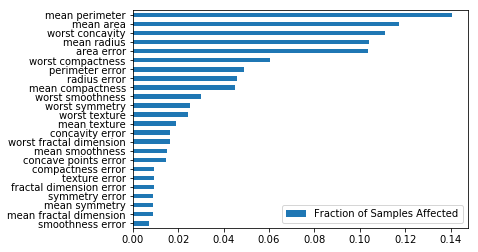

In [157]:
# Plot the feature importance
feat_scores = pd.DataFrame({'Fraction of Samples Affected' : rf.feature_importances_},
                           index=X.columns)
feat_scores = feat_scores.sort_values(by='Fraction of Samples Affected')
feat_scores.plot(kind='barh')

#### Mean Decrease Accuracy

A different approach to calculating feature importances shuffles the values of a feature, and measures the decrease in accuracy (code taken from sklearn documentation).

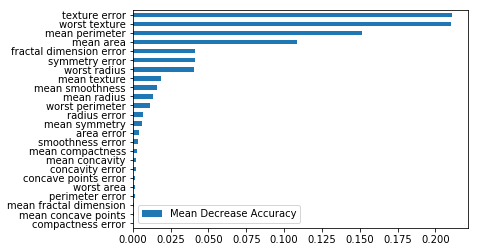

In [158]:
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import r2_score
from collections import defaultdict

rf = RandomForestRegressor()
scores = defaultdict(list)


names = data.feature_names
 
rf = RandomForestRegressor()
scores = defaultdict(list)
 
# crossvalidate the scores on a number of 
# different random splits of the data
splitter = ShuffleSplit(100, test_size=.3)

for train_idx, test_idx in splitter.split(X, y):
    X_train, X_test = X.values[train_idx], X.values[test_idx]
    y_train, y_test = y.values[train_idx], y.values[test_idx]
    rf.fit(X_train, y_train)
    acc = r2_score(y_test, rf.predict(X_test))
    for i in range(X.shape[1]):
        X_t = X_test.copy()
        np.random.shuffle(X_t[:, i])
        shuff_acc = r2_score(y_test, rf.predict(X_t))
        scores[names[i]].append((acc-shuff_acc)/acc)

score_series = pd.DataFrame(scores).mean()
scores = pd.DataFrame({'Mean Decrease Accuracy' : score_series})
scores.sort_values(by='Mean Decrease Accuracy').plot(kind='barh')